# Implementation of Stereo correspondences (Assignment #2 - Task# 2)


In [2]:
#Import necessary libraries
import os
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

In [3]:
%pwd

'C:\\Users\\sreed\\Downloads\\Assignment-2-main\\Assignment-2-main'

In [4]:
# Load all stereo images from path

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_UNCHANGED)
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return filenames, images
    

path = "images/Stereo Correspondence/"

filenames, images = load_images_from_folder(path)

In [5]:
len(images)

6

In [6]:
filenames

['1_1.jpg', '1_2.jpg', '2_1.png', '2_2.png', '3_1.jpg', '3_2.jpg']

# 1. Given two images of the same scene, perform intensity window-based correlation on the given pair of images


In [7]:
# Get Stereo pair of images ()
img1 = images[4]
img2 = images[5]
    

In [8]:
img1.shape

(720, 1280, 3)

In [9]:
img2.shape

(720, 1280, 3)

In [10]:
# resize images if left and right images are of different sizes

if img1.shape[:2] != img2.shape[:2]:
    print(img1.shape)
    print(img2.shape)
    if img1.shape[:2] > img2.shape[:2]:
        print('img1 is bigger')
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    else:
        print('img2 is bigger')
        img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
else:
    print('Left and right image sizes are equal')
    

Left and right image sizes are equal


In [86]:
1//2


0

In [93]:
print(img1.shape)

(720, 1280, 3)


In [94]:
print(img2.shape)

(720, 1280, 3)


In [68]:
img2.shape

(318, 743, 3)

In [11]:
# Convert images to grey scale

grayLeft = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Calculate the disparities

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=17)

disparity = stereo.compute(grayLeft, grayRight)




In [12]:
grayRight.shape

(720, 1280)

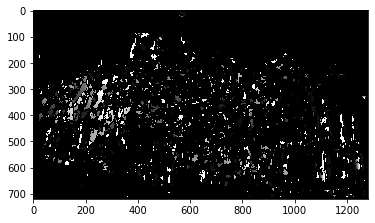

In [13]:
plt.imshow(disparity,'gray')
plt.show()

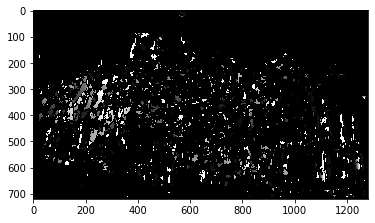

In [14]:
# Plot the disparity
plt.imshow(disparity,'gray')

plt.show()

In [17]:
type(img2)

numpy.ndarray

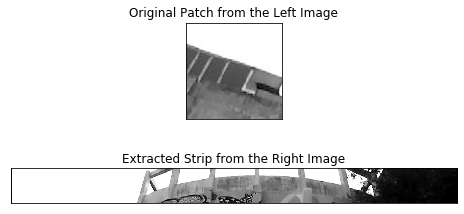

In [15]:
# define the window in left image
window_loc = [100, 120]
window_size = [100, 100]

# extract the patch from the left image
window_left = grayLeft[window_loc[0]:(window_loc[0] + window_size[0]),
                       window_loc[1]:(window_loc[1] + window_size[1])]

# extract strip from the rigth image
strip_right = grayRight[window_loc[0]:(window_loc[0] + window_size[0]), :]

fig = plt.figure(figsize=(8, 6))
fig.canvas.set_window_title('Window-based correlation')
plt.subplot(311), plt.imshow(window_left, 'gray')
plt.title('Original Patch from the Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(strip_right, 'gray')
plt.title('Extracted Strip from the Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [16]:
# FIND BEST match USING SUM OF SQUARED DIFFERENCES
# this function will find the best match location in the right strip from the window from left image
def best_match(patch, strip):
    """ Return the best x location for the patch in the strip using the sum of
    squared differences.
    Params:
    patch: The input image patch to be compared
    strip: The input strip image in which the patch is compared against
    Returns:
    best_match: The best x fit location of the patch in the strip
    """
    min_diff = float('inf')
    best_match = 0
    for x in range(0, strip.shape[1] - patch.shape[1] + 1):
        extracted_patch = strip[:, x:(x + patch.shape[1])]
        ssd = np.sum((patch - extracted_patch)**2)
        if ssd < min_diff:
            best_match = x
            min_diff = ssd

    return best_match

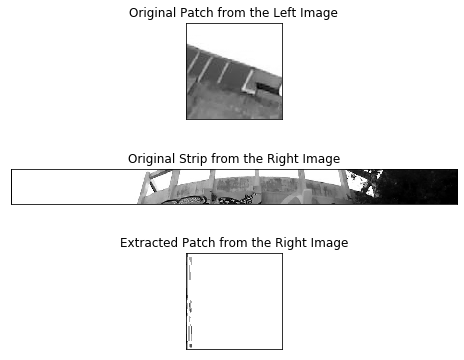

In [17]:
# get best_match and corresponding patch
x = best_match(window_left, strip_right)
patch_right = strip_right[:, x:(x + window_left.shape[1])]

# plot patch left, strip right and patch right using matplotlib
fig = plt.figure(figsize=(8, 6))
fig.canvas.set_window_title('Best Patch Detection')
plt.subplot(311), plt.imshow(window_left, 'gray')
plt.title('Original Patch from the Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(strip_right, 'gray')
plt.title('Original Strip from the Right Image'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(patch_right, 'gray')
plt.title('Extracted Patch from the Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [18]:
#FIND DISPARITY VECTOR FOR 2 STRIPS
# define strip row (y) and the square block size (b)
y = 75
b = 100

# extract strip from the images
left_strip = grayLeft[y:(y + b), :]
right_strip = grayRight[y:(y + b), :]



[-270.   97.  195.  292.  397.  230.  331.  694.  792.  892.  992. 1092.]


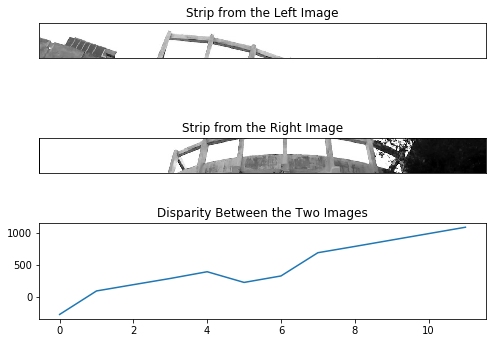

In [20]:
# define function to find disparity
def find_disparity(left_strip, right_strip, block_size):
    ''' A function for finding the pixel disparity vector between each block in
        right and left strips with the given block size. '''
    num_blocks = left_strip.shape[1] / block_size # python 2 floors integer div
    # create an empty disparity vector
    disparity = np.zeros(int(num_blocks))
    # how many times does the block fit in the strip
    for i in range(int(num_blocks)):
        x_left = i*block_size
        patch_left = left_strip[:, x_left:(x_left + block_size)] # get patch
        x_right = best_match(patch_left, right_strip)
        disparity[i] = x_left - x_right

    return disparity

# call the match strips function
disparity = find_disparity(left_strip, right_strip, b)
print(disparity)

# plot strips and disparity
fig = plt.figure(figsize=(8, 6))
fig.canvas.set_window_title('Stereo Disparity')
plt.subplot(311), plt.imshow(left_strip, 'gray')
plt.title('Strip from the Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(right_strip, 'gray')
plt.title('Strip from the Right Image'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.plot(disparity)
plt.title('Disparity Between the Two Images')

plt.show()

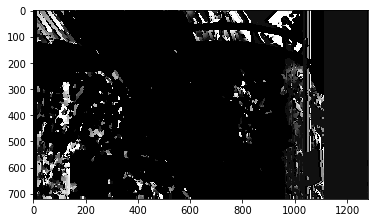

In [36]:
stereo = cv2.cv2.StereoSGBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

# 2 Select few points in the first image and then plot their corresponding epipolar lines on the second. Repeat the same for the second image

In [22]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [23]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [24]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, a = img1.shape
   # img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
   # img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

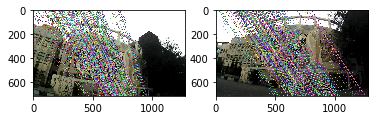

In [25]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# 3 Rectify stereo images

In [133]:
img1.shape

(720, 1280, 3)

In [27]:
# Since specific camera calibration is not done, i have used used uncalibrated version of algorithm using the fundamental matrix obtained
# in 2nd step. H1 and H2 are homography matrices
h1, w1, C = img1.shape
h2, w2, C = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1))

In [28]:
# rectified images are saved in the folder

img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)



True

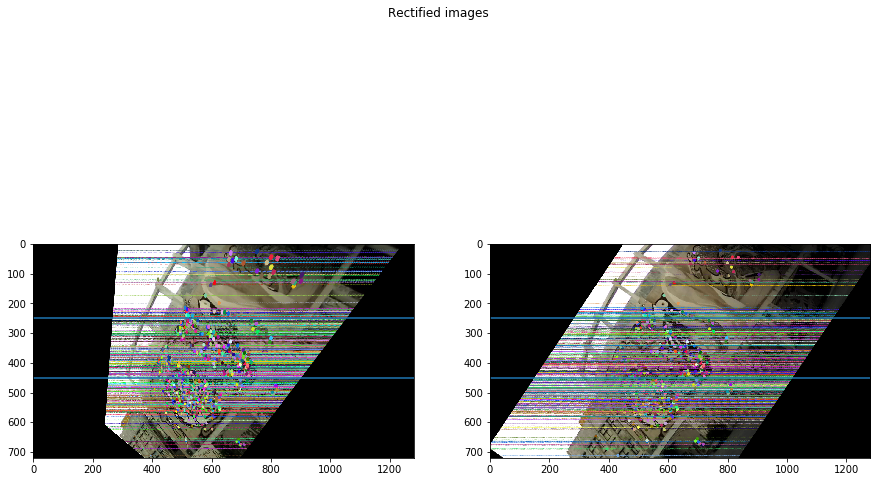

In [30]:
# Draw the rectified images. Keypoints are located on the matching epipolar lines in both images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

# 4. Compare the Brute force and Greedy based solution for the stereo correspondence problem

In [125]:
#This is the detector we're going to use for the features
orb = cv2.ORB_create()

In [126]:
#Here, we find the key points and their descriptors with the orb detector
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [127]:
# BF matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [128]:
#Here we create matches of the descriptors, then we sort them based on their distances
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

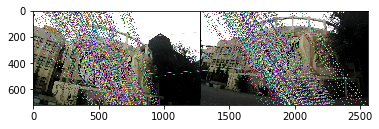

In [129]:
#Here, we've drawn the first 10 matches. The output:
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)
plt.imshow(img3)
plt.show()

# Observations

This experiment is performed on all given image pairs 1_1.jpg, 1_2.jpg, 2_1.png, 2_2.png, 3_1.jpg and 3_2.jpg. It is observed that from the pictures, it is hard to really make out the difference how stereo matching algorithms are preforming over other. However execution time for Brute Force is really quicker than Greedy matching and Flann based matching.